# Analyze A/B Test Results
_- Maithili Desai_

## Table of Contents
- [Introduction](#intro)
- [Dataset Overview](#data)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Conclusion](#conclusion)

<a id='intro'></a>
## Introduction

- A company has developed a new web page in order to try and increase the number of users who "convert," meaning the number of users who decide to pay for the company's product. 
- Through this project, my goal is to help the company understand if they should implement this new page, keep the old page, or perhaps run the experiment longer to make their decision.
- For this experiment, users are randomly given either the new page or old page thus dividing them into two groups- control and treatment.
- The control group receives the old version of page and the treatment group receives the new version.
- Based on which group of users tend to buy the product more, the efficiency of the page will be determined and thus a decision will be made on which web page to choose as the final one.
- To do this, I'll use three approaches:
     1. Probability
     2. A/B Tests
     3. Regression

<a id='data'></a>
## Dataset Overview

**ab_data.csv**
- The dataset include 294478 users
- There are 5 attributes namely:
   1. user_id: Unique Identification number for the user
   2. timestamp: Time the users visit the webpage
   3. group: The participants are divided into 2 groups: control and treatment
   4. landing_page: This states whether the user received new page or old page
   5. converted: 0 if the user did not convert and 1 if the user converted

**countries.csv**
- This dataset will be utilized for further analysis of whether the country variable will be useful addition to model
- There are 2 attributes namely:
  1. user_id: Unique Identification number for the user
  2. country: Country from where the user access the web page

<a id='probability'></a>
## Part I - Probability

Importing libraries to get started

In [102]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
# Random seed to keep the answers same in each run
random.seed(42)

Reading the dataset into a dataframe `df` and viewing the top few rows

In [103]:
# Reading the dataset into dataframe
df = pd.read_csv('ab_data.csv')

# Looking at the top few rows
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


Number of users in the dataset.

In [104]:
# Number of rows in the dataframe
df.shape[0]

294478

Number of unique users in the dataset.

In [105]:
# Number of unique users
df['user_id'].nunique()

290584

The proportion of users converted.

In [106]:
df['converted'].mean()

0.11965919355605512

Number of times the `new_page` and `treatment` don't line up.

In [107]:
df.shape[0] - df.query('group =="control" and landing_page =="old_page" or group == "treatment" and landing_page == "new_page"').count()[0]

3893

Check for the rows have missing values

In [108]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

There are some rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**. To be sure if this user truly received the new or old page, I'll only use the rows that I feel confident in the accuracy of the data.

Thus, I will create a new dataset **df2** that meets the specifications of control and experimental group for accurate analysis and insights

In [109]:
df2 = df.query('group == "control" and landing_page == "old_page" or group == "treatment" and landing_page == "new_page"')

In [110]:
# Double Check all of the correct rows were extracted - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

Unique `user_id`s in df2

In [111]:
df2['user_id'].nunique()

290584

Check for duplicated `user_id`s and their row information

In [112]:
df2[df2.duplicated(['user_id'], keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


Removing one of the duplicated `user_id`s 

In [113]:
df2 = df2.drop_duplicates(subset = 'user_id')

In [114]:
# Check for success
df2[df2.duplicated(['user_id'], keep=False)]

,user_id,timestamp,group,landing_page,converted


Probability of an individual converting regardless of the page they receive

In [115]:
df2['converted'].mean()

0.11959708724499628

Given that an individual was in the `control` group, the probability they converted

In [116]:
df2.query('group == "control"')['converted'].mean()

0.1203863045004612

Given that an individual was in the `treatment` group, the probability they converted

In [117]:
df2.query('group == "treatment"')['converted'].mean()

0.11880806551510564

Probability that an individual received the new page?

In [118]:
df2.query('landing_page == "new_page"')['user_id'].count()/df2.shape[0]

0.5000619442226688

#### Is there is sufficient evidence to say that the new treatment page leads to more conversions?

According to my results, 
- The probability of an individual converting regardless of the page they receive is low (11.9%). 
- The probability that a user lands on a new place is balanced (50%) so low number of samples in either group is not the reason
- Furthermore, the conversion rate of control group is more than the treatment group but the difference in the probability is not significant. - This small difference could also appear by chance, therefore we don't have sufficient evidence to conclude that the new treatment page leads to more conversions than the old page. 
- The possible reasons for low conversion rate per group could be due to change aversion or novelty effect
- Thus, there is no sufficient evidence to say that the new treatment page leads to more conversions

<a id='ab_test'></a>
## Part II - A/B Test

Defining the Null and Alternative hypotheses, assuming that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%.
>**$p_{old}$** and **$p_{new}$** will be the converted rates for the old and new pages.

**Hypothesis**

1. Null Hypothesis: New Page is performing as good as or worse than the Old page i.e. New page will receive less or the same number of visitors compared to the Old page
2. Alternate Hypothesis: New Page is better than the Old page i.e New page will receive more visitors than the Old page

$$H_0: p_{new} - p_{old} <= 0$$
$$H_1: p_{new} - p_{old} > 0$$

To perform A/B testing I'll:
- Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page.
- Sample size for each page is equal to the `ones` in dataset
- Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Finding parameters necessary for simulation

**convert rate** for $p_{new}$ under the null

In [119]:
# Conversion rate for new page
p_new = df2.converted.mean()
print('New conversion rate of p: ', p_new)

New conversion rate of p:  0.11959708724499628


**convert rate** for $p_{old}$ under the null

In [120]:
# Conversion rate for old page
p_old = df2.converted.mean()
print('Old conversion rate of p: ', p_old)

Old conversion rate of p:  0.11959708724499628


Number of indivduals in treatment group $n_{new}$

In [121]:
# Number of individuals in the treatment group
n_new = df2.query("group == 'treatment'").user_id.nunique()
n_new

145310

Number of individuals in the control group $n_{old}$

In [122]:
# Number of individuals in the control group
n_old = df2.query("group == 'control'").user_id.nunique()
n_old

145274

Simulating $n_{new}$ transactions with a convert rate of $p_{new}$ under the null and then storing these $n_{new}$ 1's and 0's in **new_page_converted**.

In [123]:
#simulate n transactions with a conversion rate of p with np.random.choice
new_page_converted = np.random.choice([1,0], size = n_new, replace = True, p = (p_new, 1-p_new))
new_page_converted.sum()

17554

Simulating $n_{old}$ transactions with a convert rate of $p_{old}$ under the null and then storing these $n_{old}$ 1's and 0's in **old_page_converted**.

In [124]:
old_page_converted = np.random.choice([1,0], size = n_old, replace = True, p = [p_old, (1-p_old)])
old_page_converted.sum()

17359

Finding $p_{new}$ - $p_{old}$ for the simulated values from previous 2 steps

In [125]:
new_page_converted.mean() - old_page_converted.mean()

0.0013123550204723472

Simulating 10,000 $p_{new}$ - $p_{old}$ values and storing all 10,000 values in a numpy array called **p_diffs** with bootstrap sampling

In [126]:
# Creating the sampling distribution with 10000 simulations of the steps before
p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.choice([1,0], size = n_new, replace = True, p = (p_new, 1-p_new))
    old_page_converted = np.random.choice([1,0], size = n_old, replace = True, p = (p_old, 1-p_old))
    diff = new_page_converted.mean() - old_page_converted.mean()
    p_diffs.append(diff) 

Plotting a histogram of the **p_diffs**.

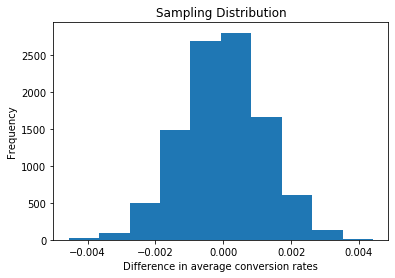

In [127]:
# Sampling Distribution
p_diffs = np.array(p_diffs)

fig=plt.figure()
plt.hist(p_diffs);
plt.title('Sampling Distribution')
plt.xlabel('Difference in average conversion rates')
plt.ylabel('Frequency');

fig.savefig('Sampling_Distribution.jpg');

Finding the proportion of the **p_diffs** that are greater than the actual difference observed in dataset

In [128]:
num_conv_treat = df2.query("group == 'treatment' and converted == 1").count()[0]
num_conv_control = df2.query("group == 'control' and converted == 1").count()[0]

p_actual_old = df2.query("group == 'control'").converted.mean()
p_actual_new = df2.query("group == 'treatment'").converted.mean()
actual_diff = p_actual_new - p_actual_old

print("Number of converted persons in control group: ",num_conv_control, "| p_old: ", p_actual_new)
print("Number of converted persons in treatment group: ",num_conv_treat, "| p_new: ", p_actual_new)
print("Actual difference: ", actual_diff)

Number of converted persons in control group:  17489 | p_old:  0.11880806551510564
Number of converted persons in treatment group:  17264 | p_new:  0.11880806551510564
Actual difference:  -0.0015782389853555567


Plotting the Null Distribution with hypothesized mean of 0

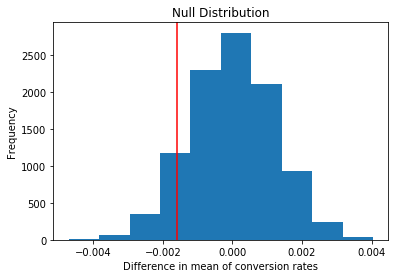

In [129]:
# Null Distribution
p_diffs = np.array(p_diffs)

#calcualte the null_vals based on the std of the p_diffs array
null_vals = np.random.normal(0, p_diffs.std(), p_diffs.size)

fig = plt.figure()
plt.hist(null_vals);
plt.title('Null Distribution')
plt.xlabel('Difference in mean of conversion rates')
plt.ylabel('Frequency')
plt.axvline(actual_diff, color = 'r');
fig.savefig('Null_Distribution.jpg');

In [130]:
(null_vals > actual_diff).mean()

0.9044

The value calculated is known as p-value which is 0.9038

**Procedure**

1. Stated Null and Alternate hypothesis
2. Assumed Null hypothesis to be true. This means that I considered that the conversion rate for the people in treatment group is same as or worse than the conversion rate in control group (p_old = p_new = 0.1195)
3. Calculated the conversion rates which are the same for both
4. Calculated the individuals in the control and treatment group (n_old, n_new)
5. The values in 3. and 4. were utilized to calculate the number of individuals who received old page and converted and who received the new page and converted (old_page_converted, new_page_converted)
6. Based on the above, I bootstrapped a sampling distribution for both pages and calculated the differences in the converting probability per page with n equal to the original number of people who received each page and a converting probability of 0.1195
7. Plotted the sampling distribution of the difference in mean of conversion rates for both groups which is from the simulated population
8. Plotted a null distribution with mean 0 (Null Hypothesis Statement) and standard deviation and size of the numpy array calculated in 6.
9. Calculated the proportion of values which are larger than the actually observed difference. 

**Insights**:

The calculated p-value now tells us the probability of receiving this observed statistic if the null hypothesis is true. With a Type-I-Error-Rate of 0.05, 0.9038 > 0.05, therefore we don't have enough evidence to reject the null hypothesis. 

**Thus we fail to reject the Null Hypothesis**

### Z-test Approach
-Similar results can be achieved using a built-in functions.  
-Calculating the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [131]:
import statsmodels.api as sm

convert_old = df2.query("group == 'control'").converted.sum()
convert_new = df2.query("group == 'treatment'").converted.sum()
n_old = df2.query("landing_page == 'old_page'").count()[0]
n_new = df2.query("landing_page == 'new_page'").count()[0]

Using `stats.proportions_ztest` to compute test statistic and p-value.

In [132]:
#https://machinelearningmastery.com/critical-values-for-statistical-hypothesis-testing/
from scipy.stats import norm

#calculate z-test
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative="smaller")

#calculate the critical z_term
z_critical=norm.ppf(1-(0.05))

print("Z-Score: ",z_score, "\nCritical Z-Score: ", z_critical, "\nP-Value: ", p_value)

Z-Score:  1.3109241984234394 
Critical Z-Score:  1.6448536269514722 
P-Value:  0.9050583127590245


**Insights**:
- The p-value calculated in this sub-section agrees with our previous findings 
- Also the calculated Z-Score is smaller than the Critical Z - Score, so we fail to reject the null hypothesis based on the Z-test.
- In conclusion, the coversion rates of the old page are equal or better than the conversion rates of the new page.

<a id='regression'></a>
## Part III - A regression approach

The result acheived in the previous A/B test can also be acheived by performing regression.
**Since this is a case of Binary Classification, I'll perform Logistics Regression**

The goal is to use **statsmodels** to fit the logistic regression model to see if there is a significant difference in conversion based on which page a customer receives.  
To do this I'll:
1. Create a column for the intercept
2. Create a dummy variable column for which page each user received
3. Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [133]:
# Copying into a new dataframe as I am going to add intercept and dummy variables
df_log = df2.copy()
df_log.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [134]:
# Adding intercept
df_log['intercept']=1

# Adding Dummy Variable
df_log = df_log.join(pd.get_dummies(df_log['group']))

# Renaming column
df_log.rename(columns = {"treatment": "ab_page"}, inplace=True)

In [135]:
# Checking for success
df_log.head()

,user_id,timestamp,group,landing_page,converted,intercept,control,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0


Using **statsmodels** to import regression model. Instantiate the model, and fit the model using the two columns created to predict whether or not an individual converts.

In [136]:
# Instantiate
y = df_log["converted"]
x = df_log[["intercept", "ab_page"]]

#load model
log_mod = sm.Logit(y,x)

#fit model
results = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


Summary of the model

In [137]:
# Model summary
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Tue, 07 Jul 2020   Pseudo R-squ.:               8.077e-06
Time:                        20:45:36   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

**The p-value associated with ab_page is 0.19.**

**Comparing to the null and alternative hypotheses in the previous part using A/B Testing**
- This value is different from the previous case due to the different approach utilized in both parts
- First case:  I calculated the probability of receiving an observed statistic if the null hypothesis is true. Therefore this is a one-sided test. 
- However, the ab_page p-value here is the result of a two sided test, because the null hypothesis for this case is, that there is no significant relationship between the conversion rate and ab_page. 

**Since the p-value is high, we can say that, ab_page is not statistically significant in predicting the conversion rate and is therefore not a meaningful addition to the model**

**Other factors that might influence whether or not an individual converts**:

1. Extracts of the time stamp, for example the day of the week whether it is a weekday or weekend 
2. Gender (if this data would be available)
3. Income infrastructure (if this data would be available). 
4. Presence/Placements of offers

**Advantage:**
- This could lead to more precise results and a higher accuracy. 

**Disadvantages:**
- Increasing complexity of interpretation 
- Possible introduction of multicollinearity due to related X variables. 

However, we can solve the problem of multicollinearity using a variety of ways such as by calculating the VIF's and elimnating the features with VIF higher than 10.

Along with testing for the conversion rate changes for different pages, I'll also add an effect based on which country a user lives using **countries.csv** dataset and merging together both datasets on the approporiate rows. This will help understand whether the country the user resides in affects the conversion or not.

In [138]:
countries_df = pd.read_csv('./countries.csv')
#df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
countries_df.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [139]:
#merge the dataframes together
df_log_country = df_log.merge(countries_df, on="user_id", how = "left")

In [140]:
df_log_country = df_log_country.join(pd.get_dummies(df_log_country['country']))
df_log_country.head()

,user_id,timestamp,group,landing_page,converted,intercept,control,ab_page,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0,US,0,0,1


In [141]:
# Instantiate
y = df_log_country["converted"]
x = df_log_country[["intercept", "ab_page", "CA", "UK"]]

# Load Model
log_mod = sm.Logit(y,x)

# Fit Model
results = log_mod.fit()

# Model Summary
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Tue, 07 Jul 2020   Pseudo R-squ.:               2.323e-05
Time:                        20:45:40   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

Based on the country-features p-values we can say, that **these features also don't have a significant impact on the coversion rate.**

However, we could interpret these coefficients as follows:

In [142]:
print("ab_page reciprocal exponential: ", 1/np.exp(-0.0149),
      "\nCA reciprocal exponential: ", 1/np.exp(-0.0408),
      "\nUK exponential: ",np.exp(0.0099))

ab_page reciprocal exponential:  1.0150115583846535 
CA reciprocal exponential:  1.0416437559600236 
UK exponential:  1.0099491671175422


This means that:
- A conversion is 1.015 times less likely, if a user receives the treatment page, holding all other variables constant
- A conversion is 1.042 times less likely, if the user lives in CA and not the US.
- A conversion is 1.00995 times more likely, if the user lives in UK and not the US.

After looking at the individual factors of country and page on conversion, I'll take a look at an interaction between page and country to see if there significant effects on conversion.  
- To do this, I'll create the necessary additional columns, and fit the new model to provide summary results, and conclusions based on the results.

In [143]:
df_log_country.head()

,user_id,timestamp,group,landing_page,converted,intercept,control,ab_page,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0,US,0,0,1


In [144]:
#create the interaction higher order term for the ab_page and country columns
df_log_country["CA_page"], df_log_country["UK_page"] = df_log_country["CA"] * df_log_country["ab_page"], df_log_country["UK"] * df_log_country["ab_page"]

In [145]:
df_log_country.head()

,user_id,timestamp,group,landing_page,converted,intercept,control,ab_page,country,CA,UK,US,CA_page,UK_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0,US,0,0,1,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0,US,0,0,1,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1,US,0,0,1,0,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1,US,0,0,1,0,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0,US,0,0,1,0,0


In [146]:
y = df_log_country["converted"]
x = df_log_country[["intercept", "ab_page", "CA", "UK", "CA_page", "UK_page"]]

log_mod = sm.Logit(y,x)
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Tue, 07 Jul 2020   Pseudo R-squ.:               3.482e-05
Time:                        20:45:43   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
ab_page       -0.0206      0.014     -1.505      0.132      -0.047       0.006
CA            -0.0175      0.038     -0.465      0.642      -0.091       0.056
UK            -0.0057      0.019     -0.306      0.760      -0.043       0.031
CA_page       -0.0469      0.054     -0.872      0.383      -0.152       0.059
UK_page        0.0314      0.027      1.181      0.238      -0.021       0.084
==============================================================================
"""

Based on these results, we can see that the **p_values for the interaction terms are definietly not significant and even decrease the significance of the original "CA" and "UK" columns. Therefore we should not include these higher order terms in our model.**

<a id='conclusions'></a>
## Conclusions

### Based on Probability
- The probability of an individual converting regardless of the page they receive is low (11.9%).
- The probability that a user lands on a new place is balanced (50%) so low number of samples in either group is not the reason
- Furthermore, the conversion rate of control group is more than the treatment group but the difference in the probability is not significant. - This small difference could also appear by chance, therefore we don't have sufficient evidence to conclude that the new treatment page leads to more conversions than the old page.
- The possible reasons for low conversion rate per group could be due to change aversion or novelty effect
- Thus, there is no sufficient evidence to say that the new treatment page leads to more conversions

### Based on A/B Tests
- **The Hypotheses for this test:**
  1. Null Hypothesis: New Page is performing as good as or worse than the Old page i.e. New page will receive less or the same number of visitors compared to the Old page
  2. Alternate Hypothesis: New Page is better than the Old page i.e New page will receive more visitors than the Old page
- **Insights:**
  - The calculated p-value now tells us the probability of receiving this observed statistic if the null hypothesis is true. With a Type-I-Error-Rate of 0.05, 0.9038 > 0.05, therefore we don't have enough evidence to reject the null hypothesis.
  - Thus we fail to reject the Null Hypothesis
- **Insights using Z-test**
  - The p-value calculated in this sub-section agrees with our previous findings
  - Also the calculated Z-Score is smaller than the Critical Z - Score, so we fail to reject the null hypothesis based on the Z-test.
  - In conclusion, the coversion rates of the old page are equal or better than the conversion rates of the new page. 

### Based on Regression
- Since the p-value is high, we can say that, ab_page is not statistically significant in predicting the conversion rate and is therefore not a meaningful addition to the model
- Based on the country-features p-values we can say, that these features also don't have a significant impact on the coversion rate.
- Interpreting linear regression model coeffients:
  - A conversion is 1.015 times less likely, if a user receives the treatment page, holding all other variables constant
  - A conversion is 1.042 times less likely, if the user lives in CA and not the US.
  - A conversion is 1.00995 times more likely, if the user lives in UK and not the US.
- p_values for the interaction terms are definietly not significant and even decrease the significance of the original "CA" and "UK" columns. Therefore we should not include these higher order terms in our model.